In [1]:
import numpy as np
import pandas as pd
import os
from scipy import stats
%matplotlib inline
print(os.listdir("ml-latest-small"))

['links.csv', 'tags.csv', 'ratings.csv', 'README.txt', 'movies.csv']


In [50]:
movie = pd.read_csv("ml-latest-small/movies.csv")
movie.columns

Index(['movieId', 'title', 'genres'], dtype='object')

In [51]:
movie.shape

(9742, 3)

In [52]:
movie.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# Feature extraction

## Add year

In [53]:
movie['year'] = movie['title'].str.extract('.*\((.*)\).*', expand=True)
movie['year'] = movie['year'].fillna(value=0)
movie['year'] = movie['year'].map(lambda x: str(x)[:4])
movie["year"] = pd.to_numeric(movie["year"])
movie.head(5)

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


## Add genres

In [54]:
unique_genres = pd.unique(movie[['genres']].values.ravel('K'))
print('#Unique genres combination: {}'.format(unique_genres.shape[0]))

#Unique genres combination: 951


In [55]:
split_genre = [unique_genres.split('|') for unique_genres in unique_genres]
genres_set = sorted(set([item for sublist in split_genre for item in sublist]))
print(genres_set)
print('#Unique genres: {}'.format(len(genres_set)))

['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
#Unique genres: 20


In [56]:
def match_genre(row, cur_genre):
    movie_genres = row['genres'].split('|')
    return int(cur_genre in movie_genres)

# create additional 20 features for content-based analysis
for genre in genres_set:
    movie[genre] = movie.apply (lambda row: match_genre(row, genre),axis=1)

In [10]:
# del movie['genres']
movie.head(10)

,movieId,title,genres,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,6,Heat (1995),Action|Crime|Thriller,1995,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,7,Sabrina (1995),Comedy|Romance,1995,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
7,8,Tom and Huck (1995),Adventure|Children,1995,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,9,Sudden Death (1995),Action,1995,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,GoldenEye (1995),Action|Adventure|Thriller,1995,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Add average raitngs

In [57]:
# import rating data and look at columsn
rating = pd.read_csv("ml-latest-small/ratings.csv")
rating.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [58]:
# what we need is that user id, movie id and rating
rating = rating.loc[:,["userId","movieId","rating"]]
rating.head(10)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
5,1,70,3.0
6,1,101,5.0
7,1,110,4.0
8,1,151,5.0
9,1,157,5.0


In [59]:
#how the ratings are distributed
rating['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a15bd4c18>]],
      dtype=object)

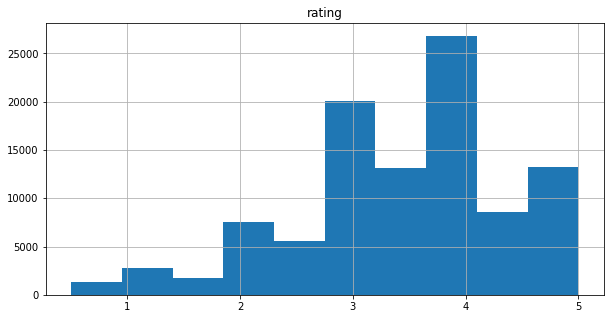

In [60]:
rating.hist(column='rating', figsize=(10,5))

In [61]:
#estimate average rating for each movie to replace missed values
avg_ratings= rating.groupby('movieId', as_index=False).mean()
del avg_ratings['userId']
avg_ratings.head()

,movieId,rating
0,1,3.920930
1,2,3.431818
2,3,3.259615
3,4,2.357143
4,5,3.071429


In [62]:
movie_content = movie.merge(avg_ratings, on='movieId', how='inner')
del movie_content['genres']
movie_content.head(3)

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
0,1,Toy Story (1995),1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,3.920930
1,2,Jumanji (1995),1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3.431818
2,3,Grumpier Old Men (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,3.259615


## Add most common tags

In [63]:
tags = pd.read_csv("ml-latest-small/tags.csv")
tags.columns

Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')

In [64]:
tags = tags.loc[:,["userId","movieId","tag"]]
tags.head(5)

,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell
3,2,89774,Boxing story
4,2,89774,MMA


In [65]:
unique_tags = pd.unique(tags[['tag']].values.ravel('K'))
print('#Unique tags: {}'.format(unique_tags.shape[0]))
print(sorted(unique_tags))

#Unique tags: 1589
['"artsy"', '06 Oscar Nominated Best Movie - Animation', '1900s', '1920s', '1950s', '1960s', '1970s', '1980s', '1990s', '2001-like', '2D animation', '70mm', "80's", 'AIDs', 'AS Byatt', 'AWESOME', 'Aardman', 'Academy award (Best Supporting Actress)', 'Action', 'Adam Sandler', 'Adrien Brody', 'Adventure', 'Afghanistan', 'Africa', 'Agatha Christie', 'Al Pacino', 'Alcatraz', 'Alfred Hitchcock', 'Alicia Vikander', 'Amazing Cinematography', 'American Indians', 'American propaganda', 'Amish', 'Amtrak', 'Amy Adams', 'Andrew Lloyd Weber', 'Andy Garcia', 'Andy Kaufman', 'Andy Samberg', 'Angelina Jolie', 'Animal movie', 'Animation', 'Anne Boleyn', 'Anne Hathaway', 'Anthony Hopkins', 'Arnold Schwarzenegger', 'Arthur C. Clarke', 'Arthur Miller', 'Astaire and Rogers', 'Atmospheric', 'Atomic bomb', 'Audrey Tautou', 'Australia', 'BEST PICTURE', 'Backwards. memory', 'Bad story', 'Bad writing', 'Batman', 'Beatles', 'Beautiful', 'Bechdel Test:Fail', 'Beethoven', 'Ben Affleck', 'Ben Kin

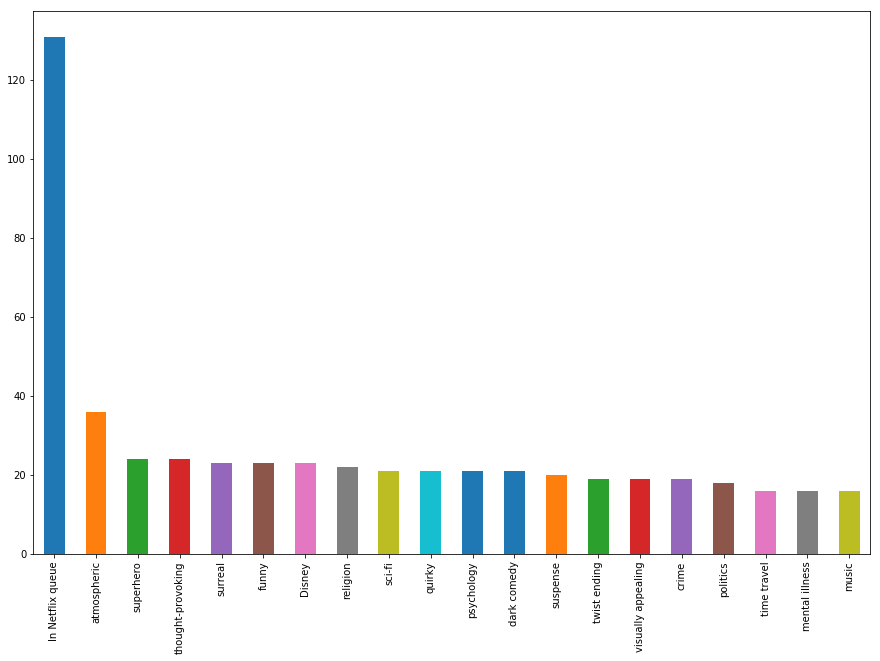

In [66]:
tag_counts = tags['tag'].value_counts()
tag_counts[:20].plot(kind='bar', figsize=(15,10))

In [67]:
tag_set = tag_counts.keys()[:15]
print(tag_set)

Index(['In Netflix queue', 'atmospheric', 'superhero', 'thought-provoking',
       'surreal', 'funny', 'Disney', 'religion', 'sci-fi', 'quirky',
       'psychology', 'dark comedy', 'suspense', 'twist ending',
       'visually appealing'],
      dtype='object')


In [68]:
def match_tag(row, cur_tag):
    cur_movie = row['movieId'] 
    return tags.loc[(tags['movieId'] == cur_movie) & (tags['tag'] == cur_tag)].shape[0]

# create additional 20 features for tags for content-based analysis
for tag in tag_set:
    movie_content[tag] = movie_content.apply (lambda row: match_tag(row, tag),axis=1)

In [76]:
movie_content.head(10)

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,funny,Disney,religion,sci-fi,quirky,psychology,dark comedy,suspense,twist ending,visually appealing
0,1,Toy Story (1995),1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,6,Heat (1995),1995,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,7,Sabrina (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,8,Tom and Huck (1995),1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,Sudden Death (1995),1995,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,GoldenEye (1995),1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**movie_content is ready for content-based analysis**. Columns [2:] are used for similarity assessment

## Example of content_based analysis

In [114]:
# user_inp="Heat (1995)"
test_movieId = 6
    
indx = movie_content[movie_content['movieId']==test_movieId].index.tolist()
indx = indx[0]
print('# row in a cosine matrix of similaraties: {}'.format(indx))

# row in a cosine matrix of similaraties: 5


In [115]:
test = movie_content.iloc[:,2:]
test = test.astype('float32')

for col in list(test.columns):
    test[col] = (test[col] - test[col].mean())/test[col].std(ddof=0)
    
similarity_with_other_movies = test.corrwith(test.iloc[indx], axis=1)  
similarity_with_other_movies = similarity_with_other_movies.sort_values(ascending=False)
similarity_with_other_movies.head(10)
# id corr

5       1.000000
5598    0.999862
4607    0.999677
793     0.999531
3597    0.998918
5259    0.998699
3406    0.998545
8258    0.998326
8386    0.998189
6517    0.997097
dtype: float64

In [116]:
index_set =  list(similarity_with_other_movies[:10].index)
movie_content.iloc[index_set]

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,funny,Disney,religion,sci-fi,quirky,psychology,dark comedy,suspense,twist ending,visually appealing
5,6,Heat (1995),1995,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5598,27022,Thursday (1998),1998,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4607,6874,Kill Bill: Vol. 1 (2003),2003,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
793,1036,Die Hard (1988),1988,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3597,4946,"Eye for an Eye, An (1981)",1981,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5259,8665,"Bourne Supremacy, The (2004)",2004,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3406,4640,Brother (2000),2000,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8258,105585,Machete Kills (Machete 2) (2013),2013,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8386,110501,The Raid 2: Berandal (2014),2014,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6517,54286,"Bourne Ultimatum, The (2007)",2007,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [117]:
movie_content.iloc[index_set]['rating']

5       3.946078
5598    4.000000
4607    3.961832
793     3.862069
3597    4.000000
5259    3.786667
3406    3.750000
8258    4.000000
8386    3.928571
6517    3.697531
Name: rating, dtype: float64

## Our prediction based on content-based approach

In [118]:
prediction_cb = movie_content.iloc[index_set]['rating'].mean()
print('average rating for similar movies: {}'.format(prediction_cb))

average rating for similar movies: 3.8932748417394114


# Raiting: Item-based approach

In [92]:
pivot_table = rating.pivot_table(index = ["userId"],columns = ["movieId"],values = "rating")
pivot_table.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,4.0,5.0,3.0,5.0,4.0,4.0,3.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
pivot_table.isnull().sum().sum()

5830804

## Fill missed values

In [126]:
pivot_table = pivot_table.fillna(pivot_table.mean())
pivot_table.head(5)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.000000,3.948276,2.435897,3.555556,4.000000,3.493631,4.500000,3.574468,3.26087,3.278571,...,4.000000,3.392593,4.000000,3.00,4.000000,2.500000,4.000000,2.500000,3.00000,5.000000
2,4.366379,3.948276,2.435897,3.555556,3.636364,4.000000,3.230263,4.000000,3.26087,3.278571,...,4.425743,4.000000,3.507953,5.00,3.500000,3.657399,3.786096,2.000000,3.27027,3.688556
3,4.000000,3.948276,2.435897,3.555556,3.636364,5.000000,3.230263,3.574468,3.26087,3.278571,...,4.425743,3.392593,3.507953,3.48,3.210407,3.657399,3.786096,2.000000,3.27027,3.688556
4,4.366379,3.948276,2.435897,3.555556,3.636364,3.000000,3.230263,3.574468,3.26087,3.278571,...,4.425743,3.392593,3.507953,3.48,3.210407,3.657399,3.786096,3.134176,3.27027,3.688556
5,4.366379,3.948276,2.435897,3.555556,3.636364,5.000000,3.230263,3.574468,3.26087,3.278571,...,4.425743,3.392593,3.507953,3.00,3.210407,3.657399,3.786096,3.134176,3.27027,3.688556


**pivot_table is ready for item-based analysis**.

In [97]:
movie_watched = pivot_table[test_movieId]

similarity_with_other_movies = pivot_table.corrwith(movie_watched) 
similarity_with_other_movies = similarity_with_other_movies.sort_values(ascending=False)
similarity_with_other_movies.head(10)

movieId
6        1.000000
293      0.378899
71033    0.318751
95377    0.300603
3450     0.276609
2412     0.267593
628      0.258933
2802     0.258888
1858     0.255443
1200     0.244471
dtype: float64

# ? How to use to predict rating

In [112]:
movieId_set =  list(similarity_with_other_movies[:10].index)
# movie_content[movie_content['movieId'] in movieId_set] # check how to filter using list

prediction_ib = movie_content[movie_content['movieId'] in movieId_set]['rating'].mean()
print('average rating for similar movies: {}'.format(prediction_ib))

TypeError: 'numpy.ndarray' object is not callable

# Raiting: User-based approach

In [122]:
pivot_table = rating.pivot_table(index = ["movieId"],columns = ["userId"],values = "rating")
pivot_table.head(10)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,3.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,5.0
7,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
pivot_table = pivot_table.fillna(pivot_table.mean())
pivot_table.head(5)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.000000,3.948276,2.435897,3.555556,4.000000,3.493631,4.500000,3.574468,3.26087,3.278571,...,4.000000,3.392593,4.000000,3.00,4.000000,2.500000,4.000000,2.500000,3.00000,5.000000
2,4.366379,3.948276,2.435897,3.555556,3.636364,4.000000,3.230263,4.000000,3.26087,3.278571,...,4.425743,4.000000,3.507953,5.00,3.500000,3.657399,3.786096,2.000000,3.27027,3.688556
3,4.000000,3.948276,2.435897,3.555556,3.636364,5.000000,3.230263,3.574468,3.26087,3.278571,...,4.425743,3.392593,3.507953,3.48,3.210407,3.657399,3.786096,2.000000,3.27027,3.688556
4,4.366379,3.948276,2.435897,3.555556,3.636364,3.000000,3.230263,3.574468,3.26087,3.278571,...,4.425743,3.392593,3.507953,3.48,3.210407,3.657399,3.786096,3.134176,3.27027,3.688556
5,4.366379,3.948276,2.435897,3.555556,3.636364,5.000000,3.230263,3.574468,3.26087,3.278571,...,4.425743,3.392593,3.507953,3.00,3.210407,3.657399,3.786096,3.134176,3.27027,3.688556


In [125]:
test_userId = 2

movie_watched = pivot_table[test_userId]
similarity_with_other_users = pivot_table.corrwith(movie_watched) 
similarity_with_other_users = similarity_with_other_movies.sort_values(ascending=False)
similarity_with_other_users.head(10)

userId
2      1.000000
189    0.134677
246    0.106334
378    0.099583
209    0.089539
227    0.085428
326    0.079273
393    0.063399
332    0.062821
196    0.050699
dtype: float64

# ? How to use to predict rating